The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc.

The dataset (dataset about the westbound traffic on the I-94 Interstate highway) available, and you can download it from the __[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)__ 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Traffic=pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
Traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
%matplotlib inline

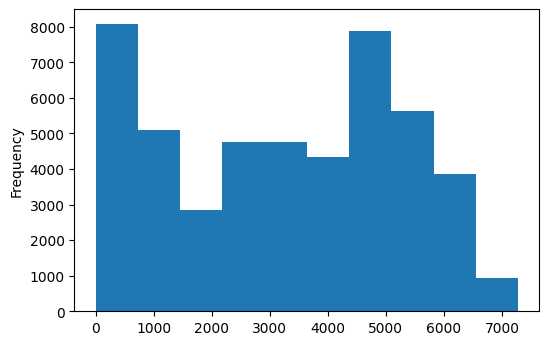

In [5]:
Traffic['traffic_volume'].plot.hist()

In [6]:
Traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


About 25% of the time, there were only 1,193 cars or fewer passing the station each hour — this probably occurs during the night. However, about 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This observation gives our analysis an interesting direction: comparing daytime data with nighttime data.

In [7]:
Traffic['date_time'] = pd.to_datetime(Traffic['date_time'])

day = Traffic.copy()[(Traffic['date_time'].dt.hour >= 7) & (Traffic['date_time'].dt.hour < 19)]
print(day.shape)

night = Traffic.copy()[(Traffic['date_time'].dt.hour >= 19) | (Traffic['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


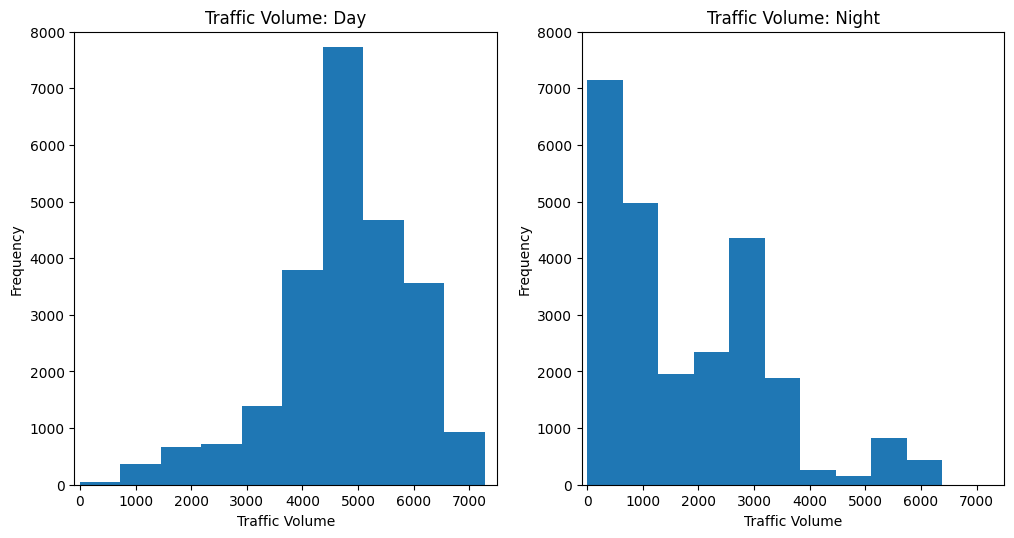

In [9]:
# Now that we've isolated day and night, we're going to look at the histograms of traffic volume side-by-side by using a grid chart.
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.show()

The histogram that shows the distribution of traffic volume during the day is left skewed. This means that most of the traffic volume values are high — there are 4,252 or more cars passing the station each hour 75% of the time (because 25% of values are less than 4,252 based on DataFrame.describe()).

The histogram displaying the nighttime data is right skewed. This means that most of the traffic volume values are low — 75% of the time, the number of cars that passed the station each hour was less than 2,819 DataFrame.describe().

For future analysis we will use day time

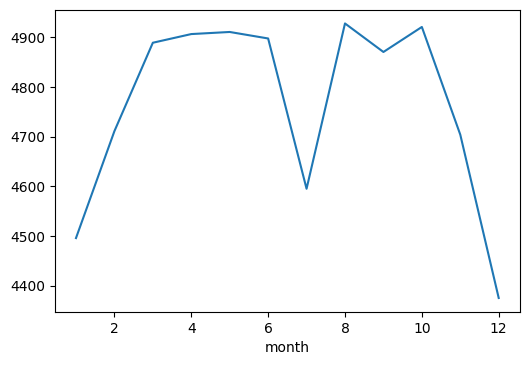

In [10]:
# Try to find correlation with time: Month, Day and Time of day
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot.line()
plt.show()

 To clarify lower level in June,  i will check years and month=July (7)

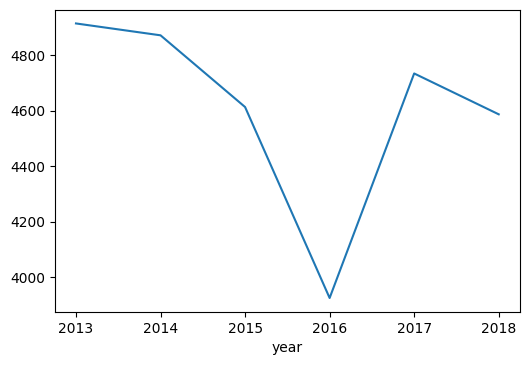

In [11]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction — this article from 2016 supports this hypothesis.

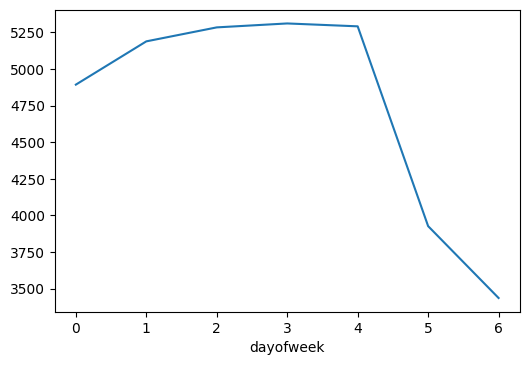

In [12]:
#Let's now look at a more granular indicator: day number.

day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot.line()
plt.show()

Traffic volume is significantly heavier on business days (Monday – Friday). Except for Monday, we only see values over 5,000 during business days. Traffic is lighter on weekends, with values below 4,000 cars.

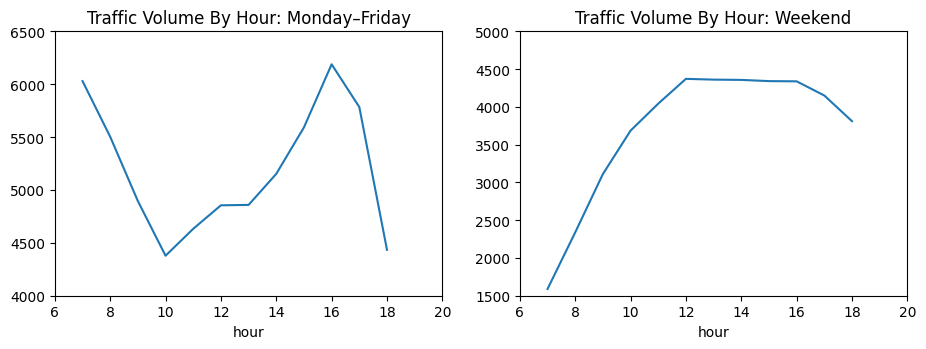

In [15]:
# Check time of day
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 = Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()


plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(4000,6500)
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,5000)
plt.title('Traffic Volume By Hour: Weekend')

plt.show()

## Summary:
we found a few time-related indicators of heavy traffic:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

### Weather 

In [17]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

The most correlation we saw with Temperature. Let's make deeply analysis

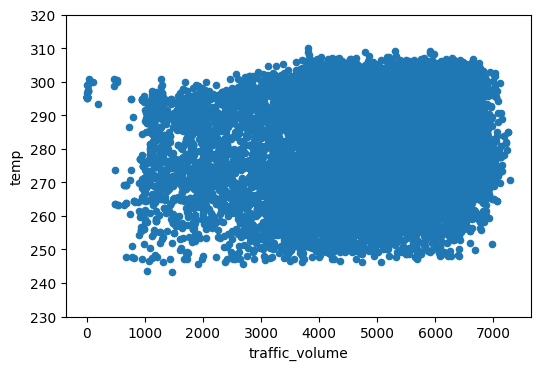

In [18]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(230, 320) # two wrong 0K temperatures mess up the y-axis
plt.show()

We could not see any paterns and correlation

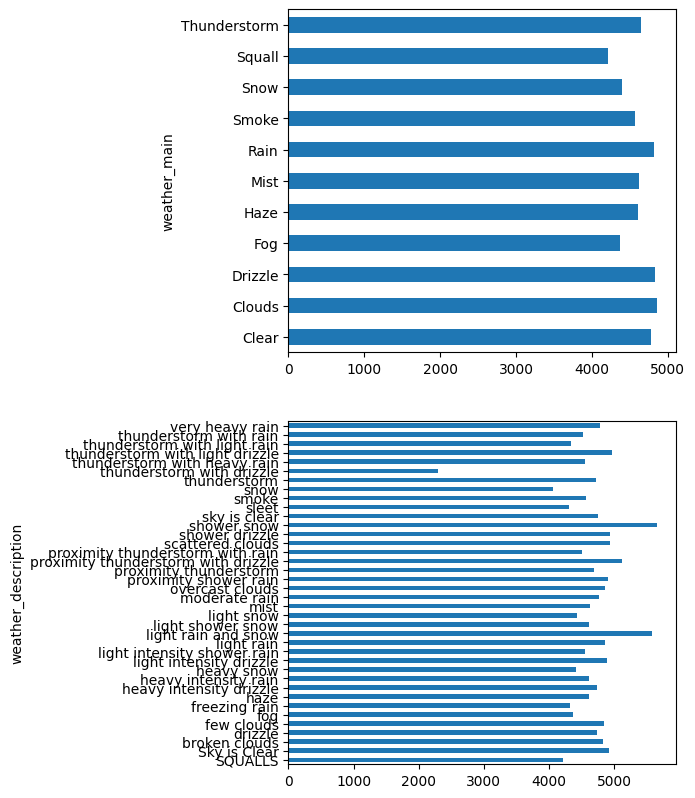

In [23]:
# look at the other weather-related columns: weather_main and weather_description.
by_weather_main = day.groupby('weather_main').mean()

plt.figure(figsize=(6,12))

plt.subplot(2, 1, 1)
by_weather_main['traffic_volume'].plot.barh()

by_weather_description = day.groupby('weather_description').mean()
plt.subplot(2, 1, 2)
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

there are three weather types where traffic volume exceeds 5,000:

- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

## Conclusion
In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

- Time indicators
1. The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
2. The traffic is usually heavier on business days compared to the weekends.
3. On business days, the rush hours are around 7 and 16.
- Weather indicators
1. Shower snow
2. Light rain and snow
3. Proximity thunderstorm with drizzle